In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu

import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

import wandb

import utils

In [2]:
# Parameter
TRAIN_DATA_DIR = './dataset/SYNTHIA-SF/SEQ1/'
VAL_DATA_DIR = './dataset/SYNTHIA-SF/SEQ2/'
TEST_DATA_DIR = './dataset/SYNTHIA-SF/SEQ3/'

# Define the Dataset Folder
x_train_dir = os.path.join(TRAIN_DATA_DIR, 'RGBLeft')
y_train_dir = os.path.join(TRAIN_DATA_DIR, 'GTLeft')

x_valid_dir = os.path.join(VAL_DATA_DIR, 'RGBLeft')
y_valid_dir = os.path.join(VAL_DATA_DIR, 'GTLeft')

x_test_dir = os.path.join(TEST_DATA_DIR, 'RGBLeft')
y_test_dir = os.path.join(TEST_DATA_DIR, 'GTLeft')

In [3]:
# Augmentation Parameter
input_width = 640
input_height = 640

In [4]:
CLASSES = ['void', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', 'traffic_sign',
            'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle',
            'road_lines', 'other', 'road_works']

# CLASSES = ['car']

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset as BaseDataset

class SYNTHIADataset(BaseDataset):
    """SYNTHIA Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['void', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', 'traffic_sign',
                'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle',
                'road_lines', 'other', 'road_works']
                
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # read the mask annotation
        mask = cv2.imread(self.masks_fps[i])
        mask = mask[..., 2]  # red channel contains labels
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [6]:
from collections import namedtuple

import numpy as np

class Labels:

    Label_entry = namedtuple("Label_entry", ['name', 'color'],)

    """
    The total number of classes in the training set.
    """
    NUM_CLASSES = 19
    
    """
    ID is equal to index in this array.
    """
    COLOURS = [
        Label_entry('void', (0, 0, 0)),                 # ID = 0
        Label_entry('road', (128, 64, 128)),            # ID = 1
        Label_entry('sidewalk', (244, 35, 232)),        # ID = 2
        Label_entry('building', (70, 70, 70)),          # ID = 3
        Label_entry('wall', (102, 102, 156)),           # ID = 4
        Label_entry('fence', (190, 153, 153)),          # ID = 5
        Label_entry('pole', (153, 153, 153)),           # ID = 6
        Label_entry('traffic light', (250, 170, 30)),   # ID = 7
        Label_entry('traffic sign', (220, 220, 0)),     # ID = 8
        Label_entry('vegetation', (107, 142, 35)),      # ID = 9
        Label_entry('terrain', (152, 251, 152)),        # ID = 10   
        Label_entry('sky', (70, 130, 180)),             # ID = 11
        Label_entry('person', (220, 20, 60)),           # ID = 12
        Label_entry('rider', (255, 0, 0)),              # ID = 13
        Label_entry('car', (0, 0, 142)),                # ID = 14
        Label_entry('truck', (0, 0, 70)),               # ID = 15
        Label_entry('bus', (0, 60, 100)),               # ID = 16
        Label_entry('train', (0, 80, 100)),             # ID = 17
        Label_entry('motorcycle', (0, 0, 230)),         # ID = 18
        Label_entry('bicycle', (119, 11, 32)),          # ID = 19
        Label_entry('road_lines', (157, 234, 50)),      # ID = 20
        Label_entry('other', (72, 0, 98)),              # ID = 21
        Label_entry('road_works', (167, 106, 29))       # ID = 22
    ]

    """
    Label is numpy array object!
    """

    @staticmethod
    def colorize(label):
        
        #Unlabelled pixels are black (zero)!
        colorized = np.zeros((label.shape[0], label.shape[1], 3), dtype = np.uint8)

        for idx in range(len(Labels.COLOURS)):
            colorized[idx == label] = Labels.COLOURS[idx].color

        return colorized  # Numpy array object!

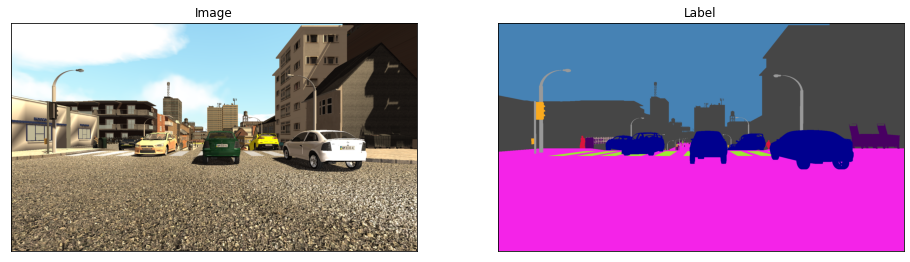

In [11]:
labels_utils = Labels()

def ColorizeSYNTHIALabel(mask):
    
    n_class = len(mask[1, 1, :])
    
    for i in range(n_class):
        class_mask = mask[:,:,i]
        mask[class_mask == 1.0] = i
    
    array = mask[:, :, 1]
    label_colorized = labels_utils.colorize(array)
        
    return label_colorized

trainDataset = SYNTHIADataset(images_dir=x_train_dir,
                                masks_dir=y_train_dir,
                                classes=CLASSES)

image, mask = trainDataset[1]

colorized = ColorizeSYNTHIALabel(mask)

utils.visualize(
    image=image, 
    label=colorized,
)